In [35]:
import requests
import pandas as pd

# Api information
api_key = '2BC570C4-A479-4292-9A7F-7635BCEAB3F3'
api_link = 'https://apps.bea.gov/api/data/'

# Parameters for the API request
params = {
    'UserID': api_key,
    'method': 'GetData',
    'datasetname': 'Regional',
    'LineCode' : '1',
    'TableName': 'SARPP',
    'GeoFips' : 'STATE',
    'Year' : '2022',
    'ResultFormat': 'JSON',  
}

response = requests.get(api_link, params=params)

if response.status_code == 200:
    api_data = response.json()
    data = api_data['BEAAPI']['Results']['Data']
    df = pd.DataFrame(data)

In [36]:
# Parameters for the second API request
params2 = {
    'UserID': api_key,
    'method': 'GetData',
    'datasetname': 'Regional',
    'LineCode' : '30',
    'TableName': 'SAINC5N',
    'GeoFips' : 'STATE',
    'Year' : '2022',
    'ResultFormat': 'JSON',  
}

response2 = requests.get(api_link, params=params2)

if response2.status_code == 200:
    api_data2 = response2.json()
    data2 = api_data2['BEAAPI']['Results']['Data']
    df2 = pd.DataFrame(data2)   

In [37]:
# Clean dataframe
df3 = pd.merge(df,df2, on = 'GeoName', how = 'inner')
df4 = pd.DataFrame()
df4['State'] = df3['GeoName']
df4['Year'] = df3['TimePeriod_x']
df4['Year'] = pd.to_datetime(df4['Year'], format='%Y').dt.year
df4['Income'] = df3['DataValue_y'].astype(float)
df4['Price Parities'] = df3['DataValue_x'].astype(float)
df4['Standardized Income'] = df4['Income'] / (df4['Price Parities'] / 100)
df4['Standardized Income'] = df4['Standardized Income'].round(2)
df4.drop(df4[df4['State'] == 'District of Columbia'].index, inplace=True)
df4.sort_values(by="Standardized Income", ascending=False, inplace=True)
df4.reset_index(drop=True, inplace=True)

<Axes: >

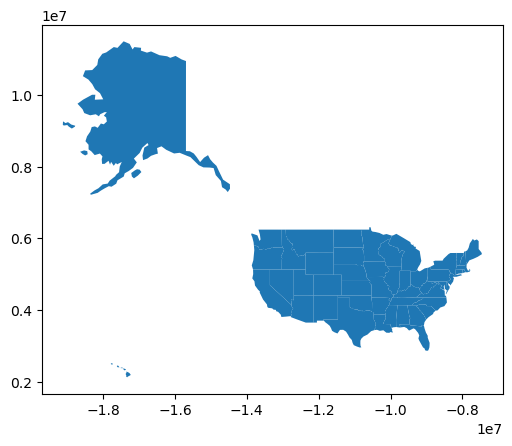

In [38]:
# Set up choropleth map
import geopandas as gpd
import matplotlib.pyplot as plt
geojson_path = 'data/ne_110m_admin_1_states_provinces.shp'
states = gpd.read_file(geojson_path)
states = states.to_crs("EPSG:3395")
states.plot()

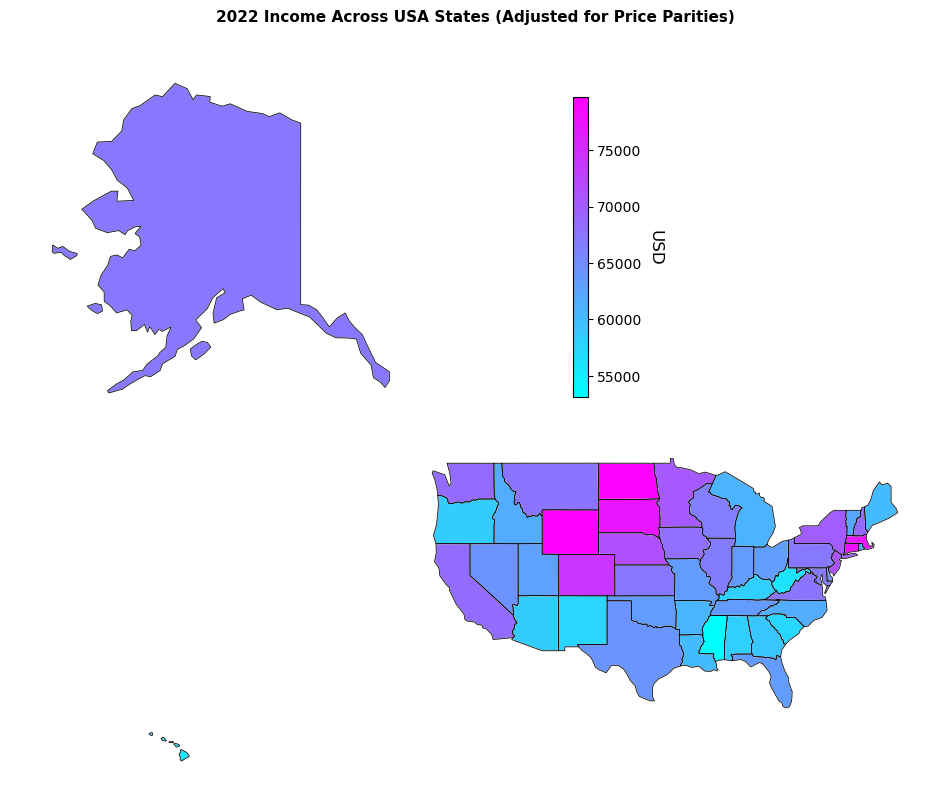

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from numpy.random import randint

# Create merged data frame to plot choropleth
merged_df = pd.merge(states, df4, left_on='name', right_on='State')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_df.plot(column='Standardized Income', cmap='cool', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
merged_df.boundary.plot(ax=ax, color='Black', linewidth=.5)

# Adjust the color bar
cbar = fig.get_figure().get_axes()[1]
cbar.set_ylabel("USD", rotation=270, labelpad=15, fontsize=12)
cbar.tick_params(labelsize=10)
cbar.set_position([0.5, 0.52, 0.02, 0.3])

# Set up title for plot
title_text = f"{merged_df['Year'].max()} Income Across USA States (Adjusted for Price Parities)"
font = {'family': 'sans-serif', 'color':  'black', 'weight': 'bold', 'size': 11}
ax.set_title(title_text, fontdict=font, loc='center', pad=20)

ax.set_axis_off()
plt.show()

In [42]:
# Export dataframe to csv
price_parities_csv = 'price_parities.csv'
personal_income_csv = 'personal_income.csv'
combined_csv = 'combined.csv'

df.to_csv(price_parities_csv, index=False)
df2.to_csv(personal_income_csv, index=False)
df4.to_csv(combined_csv, index=False)

In [48]:
# Add State code column for plotting purpose
merged_df['State Code'] = merged_df['iso_3166_2'].str.split('-', expand=True)[1]

# Create continental US, Hawaii, and Alaska dataframe for plotting purpose
cus = merged_df[~merged_df['State'].isin(['Hawaii', 'Alaska'])]
h = merged_df[merged_df['State'].isin(['Hawaii'])]
a = merged_df[merged_df['State'].isin(['Alaska'])]


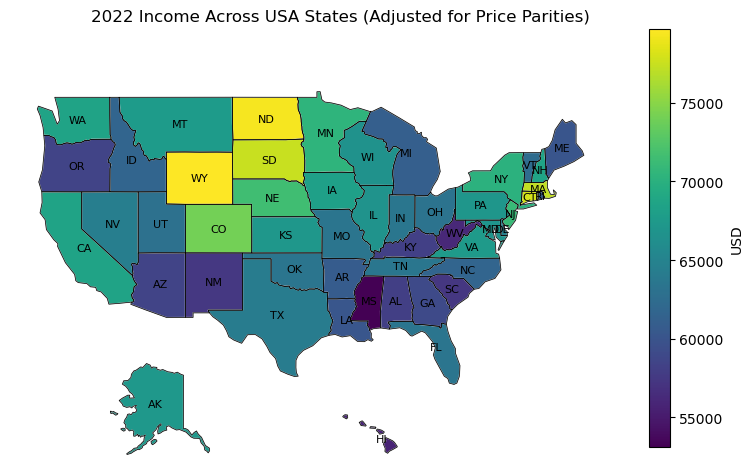

In [49]:
# Calculate min and max values for color normalization
min_value = min(merged_df['Standardized Income'])
max_value = max(merged_df['Standardized Income'])

fig = plt.figure(figsize=(12, 10))  # Increased the figure size

gs = gridspec.GridSpec(3, 2, width_ratios=[8, 1], height_ratios=[8, 4, 1])  # 3 rows, 2 columns

# Plot the first layer
ax0 = plt.subplot(gs[0, 0])
cus.plot(column='Standardized Income', linewidth=0.8, ax=ax0, edgecolor='0.8', legend = True,
         vmin=min_value, vmax=max_value, label='Layer 1', legend_kwds={'label': 'USD'})
cus.boundary.plot(ax=ax0, color='Black', linewidth=.5)

# Plot the second layer
ax1 = plt.subplot(gs[1, 0])  
a.plot(column='Standardized Income', linewidth=0.8, ax=ax1, edgecolor='0.8',
       vmin=min_value, vmax=max_value, label='Layer 2')
a.boundary.plot(ax=ax1, color='Black', linewidth=.5)

# Plot the third layer
ax2 = plt.subplot(gs[2, 0]) 
h.plot(column='Standardized Income', linewidth=0.8, ax=ax2, edgecolor='0.8',
       vmin=min_value, vmax=max_value, label='Layer 3')
h.boundary.plot(ax=ax2, color='Black', linewidth=.5)

# Set the title
title_text = f"{merged_df['Year'].max()} Income Across USA States (Adjusted for Price Parities)"
font = {'family': 'sans-serif', 'color': 'black', 'weight': 'bold', 'size': 15}
plt.suptitle(title_text, fontdict=font, y=0.9, x=0.4)

for x, y, label in zip(cus.geometry.centroid.x, cus.geometry.centroid.y, cus['State Code']):
    ax0.text(x, y, label, fontsize=8, ha='center', va='center')
for x, y, label in zip(a.geometry.centroid.x, a.geometry.centroid.y, a['State Code']):
    ax1.text(x, y, label, fontsize=8, ha='center', va='center')
for x, y, label in zip(h.geometry.centroid.x, h.geometry.centroid.y, h['State Code']):
    ax2.text(x, y, label, fontsize=8, ha='center', va='center')

# Adjust the position of the second axis
ax1.set_position([0.2, 0.45, 0.1, 0.1])
ax2.set_position([0.4, 0.45, 0.05, 0.05]) 

# Turn off the axis for all plots
ax0.set_axis_off()
ax1.set_axis_off()
ax2.set_axis_off()


# Show the plot
plt.show()


In [50]:
# Import computer science data csv
cdf = pd.read_csv('ComputerScience.csv')
cdf2 = pd.merge(df,cdf, left_on='GeoName', right_on='State', how = 'inner')

# Set up dataframe for plotting
ddf = pd.DataFrame()
ddf['State'] = cdf2['GeoName']
ddf['Income'] = cdf2['Typical Annual Salary'].replace('[\$,]', '', regex=True).astype(float)
ddf['Price Parities'] = cdf2['DataValue'].astype(float)
ddf['Standardized Income'] = ddf['Income'] / (df4['Price Parities'] / 100)
ddf['Standardized Income'] = ddf['Standardized Income'].round(2)
ddf.sort_values(by="Standardized Income", ascending=False, inplace=True)
ddf.reset_index(drop=True, inplace=True)


In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from numpy.random import randint

# Merged dataframe on states
mddf = pd.merge(states, ddf, left_on='name', right_on='State')
mddf['State Code'] = mddf['iso_3166_2'].str.split('-', expand=True)[1]

# Create continental US, Hawaii, and Alaska dataframe for plotting purpose
ccus = mddf[~mddf['State'].isin(['Hawaii', 'Alaska'])]
ch = mddf[mddf['State'].isin(['Hawaii'])]
ca = mddf[mddf['State'].isin(['Alaska'])]

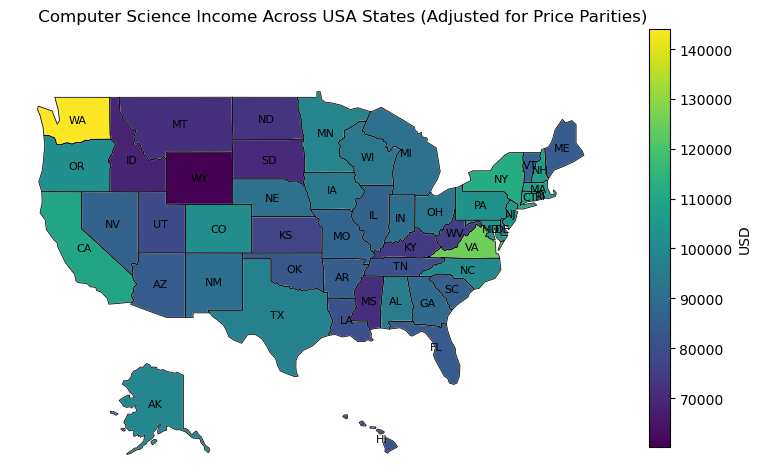

In [52]:

# Calculate min and max values for color normalization
min_value = min(mddf['Standardized Income'])
max_value = max(mddf['Standardized Income'])

fig = plt.figure(figsize=(12, 10))  # Increased the figure size

gs = gridspec.GridSpec(3, 2, width_ratios=[8, 1], height_ratios=[8, 4, 1])  # 3 rows, 2 columns

# Plot the first layer
ax0 = plt.subplot(gs[0, 0])
ccus.plot(column='Standardized Income', linewidth=0.8, ax=ax0, edgecolor='0.8', legend = True,
         vmin=min_value, vmax=max_value, label='Layer 1', legend_kwds={'label': 'USD'})
ccus.boundary.plot(ax=ax0, color='Black', linewidth=.5)

# Plot the second layer 
ax1 = plt.subplot(gs[1, 0])  
ca.plot(column='Standardized Income', linewidth=0.8, ax=ax1, edgecolor='0.8',
       vmin=min_value, vmax=max_value, label='Layer 2')
ca.boundary.plot(ax=ax1, color='Black', linewidth=.5)

# Plot the third layer 
ax2 = plt.subplot(gs[2, 0]) 
ch.plot(column='Standardized Income', linewidth=0.8, ax=ax2, edgecolor='0.8',
       vmin=min_value, vmax=max_value, label='Layer 3')
ch.boundary.plot(ax=ax2, color='Black', linewidth=.5)

# Set the title
title_text = f" Computer Science Income Across USA States (Adjusted for Price Parities)"
font = {'family': 'sans-serif', 'color': 'black', 'weight': 'bold', 'size': 15}
plt.suptitle(title_text, fontdict=font, y=0.9, x=0.4)

# Add name of state on map
for x, y, label in zip(ccus.geometry.centroid.x, ccus.geometry.centroid.y, ccus['State Code']):
    ax0.text(x, y, label, fontsize=8, ha='center', va='center')
for x, y, label in zip(ca.geometry.centroid.x, ca.geometry.centroid.y, ca['State Code']):
    ax1.text(x, y, label, fontsize=8, ha='center', va='center')
for x, y, label in zip(ch.geometry.centroid.x, ch.geometry.centroid.y, ch['State Code']):
    ax2.text(x, y, label, fontsize=8, ha='center', va='center')

# Adjust the position of the second axis
ax1.set_position([0.2, 0.45, 0.1, 0.1])
ax2.set_position([0.4, 0.45, 0.05, 0.05])

# Turn off the axis for all plots
ax0.set_axis_off()
ax1.set_axis_off()
ax2.set_axis_off()


# Show the plot
plt.show()